In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import rand_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [2]:
np.random.seed(42)

In [3]:
df_full = pd.read_csv('mushrooms.csv')
df_full.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
df_full["class"].head()

0    p
1    e
2    e
3    p
4    e
Name: class, dtype: object

Tenemos ya una clasificacion, como el objetivo es generar clusters usando distancias gower, voy a quitar la variable "class"

In [5]:
target = df_full[['class']]
data_no_target = df_full.drop(['class'],axis=1)
data_no_target.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


Explorando los datos... identificar los tipos de datos que se tienen.

In [6]:
data_no_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

tenemos que todas las variables son categoricas ademas se aprecia que no hay valores *missing*. se tiene que identificar tabmien cuantas categorias por variable tenemos

In [7]:
data_no_target.nunique()

cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64

de este conteo, se tiene que existe una variable que cuenta con una sola categoria, al no haber valores ausentes, se tiene entonces que esta variable tiene el mismo valor SIEMPRE, por lo cual no es de utilidad... se procede a eliminarla.

In [8]:
data_categorical = data_no_target.drop(['veil-type'], axis=1)

## Gower distance 

In [9]:
import gower

In [10]:
distance_matrix = gower.gower_matrix(data_categorical)
distance_matrix

array([[0.        , 0.33333334, 0.42857143, ..., 0.61904764, 0.5714286 ,
        0.5714286 ],
       [0.33333334, 0.        , 0.23809524, ..., 0.61904764, 0.6666667 ,
        0.5714286 ],
       [0.42857143, 0.23809524, 0.        , ..., 0.5714286 , 0.6666667 ,
        0.61904764],
       ...,
       [0.61904764, 0.61904764, 0.5714286 , ..., 0.        , 0.6666667 ,
        0.14285715],
       [0.5714286 , 0.6666667 , 0.6666667 , ..., 0.6666667 , 0.        ,
        0.6666667 ],
       [0.5714286 , 0.5714286 , 0.61904764, ..., 0.14285715, 0.6666667 ,
        0.        ]], dtype=float32)

### Un poco de teoria...

Con distancias Gower se puede mezclar datos categoricos y numericos.
Al momento de hacer clusters es importante tener en cuenta que el metodo *ward* solo puede trabajar con distancias euclideanas, por lo tanto cuando se utilice Gower, no es posible utilizar Ward como metodo de identificacion.

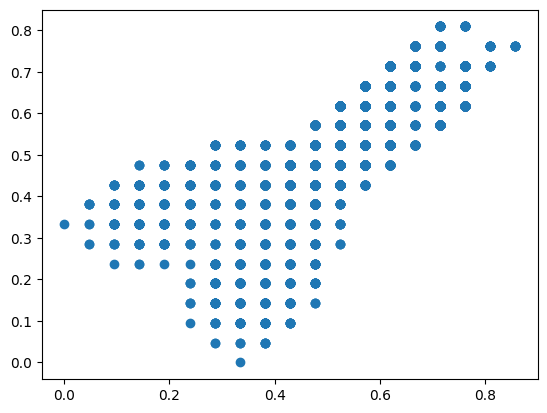

In [11]:
plt.scatter(distance_matrix[:,0], distance_matrix[:,1])
plt.show()

Nota: el conjunto de datos original contaba con la variable *class* que indicaba si el hongo en cuestion era venenoso (p) o era comestible (e), por lo tanto, para comparar que tan bien clasificamos, vamos a hacer 2 cluster, tratando de imitar la variable objetivo

In [12]:
model = AgglomerativeClustering(n_clusters=2, linkage='single')

In [13]:
encoder = preprocessing.LabelEncoder()

encoded_target = target.apply(encoder.fit_transform)

print(f'in this encoding, {encoded_target.iloc[0].values} represents {target.iloc[0].values}')

labels = pd.DataFrame()
labels['target'] = encoded_target.values.reshape(1, -1).tolist()[0]

in this encoding, [1] represents ['p']


In [14]:
clusters_single = model.fit_predict(distance_matrix)

In [15]:
labels['single-predictions'] = clusters_single

In [16]:
sri = rand_score(encoded_target.values.reshape(1, -1)[0], clusters_single)
print(f'Rand Index: {sri}')

Rand Index: 0.5629578296226294


<Axes: ylabel='count'>

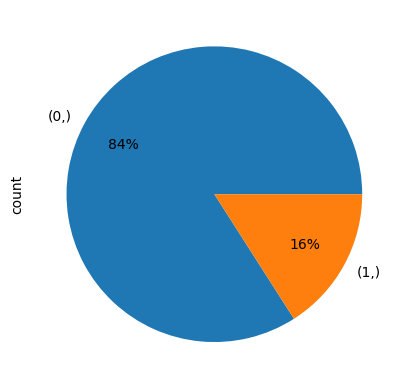

In [17]:
labels[['single-predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

en teoria esta muestra tiene 50% y 50% de p y de e.... asi que el que nos salga 84% y 16% esta lejos de una adecuada clasificacion... let's try with other method...

In [18]:
model_complete = AgglomerativeClustering(n_clusters=2, linkage='complete')
clusters_complete = model_complete.fit_predict(distance_matrix)

/home/diego/.local/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [19]:
labels['complete-predictions'] = clusters_complete

In [20]:
cri = rand_score(encoded_target.values.reshape(1, -1)[0], clusters_complete)
print(f'Rand Index: {cri}')

Rand Index: 0.8130040630233838


<Axes: ylabel='count'>

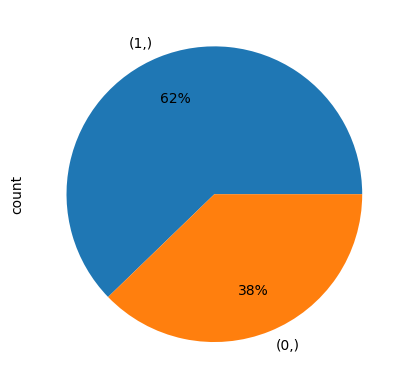

In [21]:
labels[['complete-predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

sigue siendo bajo... habra que probar con otro metodo de cluster...